# Foundations of Computational Economics #42

by Fedor Iskhakov, ANU

<img src="_static/img/dag3logo.png" style="width:256px;">

## Solving consumption-savings model with EGM

<img src="_static/img/lab.png" style="width:64px;">

<img src="_static/img/youtube.png" style="width:65px;">

[https://youtu.be/l3tNEh1Q-HQ](https://youtu.be/l3tNEh1Q-HQ)

Description: Implementation of endogenous gridpoint method for solving Deaton’s consumption-savings model.

1. Implement EGM solver in the `deaton` class  
1. Compare accuracy of solutions using squared Euler residuals:  
  - VFI with continuous choices  
  - Time iterations  
  - EGM  
1. Run the Keane’s test of flat simulated consumption profile  


(see video 40 for previous steps in developing this code, and video 41 for EGM theory)

In [1]:
# code developed in the video
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interpolate
from scipy.stats import lognorm
from scipy.optimize import minimize_scalar, brentq

class deaton():
    '''Implementation of the stochastic Deaton consumption-savings problem with random income.'''

    def __init__(self, Mbar=10,
                 ngrid=50, nchgrid=100, nquad=10,
                 interpolation='linear', bellman_type='discretized',
                 maxiter_internal=250, tol_internal=1e-10,
                 beta=.9, R=1.05, sigma=1.):
        '''Object creator for the stochastic consumption-savings model'''
        self.beta = beta        # Discount factor
        self.R = R              # Gross interest
        self.sigma = sigma      # Param in log-normal income distribution
        self.Mbar = Mbar        # Upper bound on wealth
        self.ngrid = ngrid      # Number of grid points in the state space
        self.nchgrid = nchgrid  # Number of grid points in the decision space
        self.nquad = nquad      # Number of quadrature points
        self.interpolation = interpolation  # type of interpolation, see below
        self.bellman_type = bellman_type  # type of Bellman operator
        self.maxiter_internal = maxiter_internal  # maxiter for continuous Bellman operator
        self.tol_internal = tol_internal  # tolerance for continuous Bellman operator
        # state and choice space grids, as well as quadrature points and weights are set with setter functions below

    def __repr__(self):
        '''String representation for the model'''
        return 'Deaton model with beta={:1.3f}, sigma={:1.3f}, gross return={:1.3f}\nGrids: state {} points up to {:1.1f}, choice {} points, quadrature {} points\nInterpolation: {}\nThe model is {}solved.'\
               .format(self.beta,self.sigma,self.R,self.ngrid,self.Mbar,self.nchgrid,self.nquad,self.interpolation,'' if hasattr(self,'solution') else 'not ')

    @property
    def ngrid(self):
        '''Property getter for the ngrid parameter'''
        return self.__ngrid

    @ngrid.setter
    def ngrid(self,ngrid):
        '''Property setter for the ngrid parameter'''
        self.__ngrid = ngrid
        epsilon = np.finfo(float).eps # smallest positive float number difference
        self.grid = np.linspace(epsilon,self.Mbar,ngrid) # grid for state space

    @property
    def nchgrid(self):
        '''Property getter for the nchgrid parameter'''
        return self.__nchgrid

    @nchgrid.setter
    def nchgrid(self,nchgrid):
        '''Property setter for the nchgrid parameter'''
        self.__nchgrid = nchgrid
        epsilon = np.finfo(float).eps # smallest positive float number difference
        self.chgrid = np.linspace(epsilon,self.Mbar,nchgrid) # grid for state space

    @property
    def bellman_type(self):
        '''Property getter for the bellman_type parameter'''
        return self.__bellman_type

    @bellman_type.setter
    def bellman_type(self,value):
        '''Property setter for the bellman_type parameter'''
        self.__bellman_type = value
        if value == 'discretized':
            self.bellman = self.bellman_discretized
        elif value == 'continuous':
            self.bellman = self.bellman_continuous
        else:
            raise RuntimeError('Unknown Bellman type parameter')

    @property
    def sigma(self):
        '''Property getter for the sigma parameter'''
        return self.__sigma

    @sigma.setter
    def sigma(self,sigma):
        '''Property setter for the sigma parameter'''
        self.__sigma = sigma
        self.__quadrature_setup()  # update quadrature points and weights

    @property
    def nquad(self):
        '''Property getter for the number of quadrature points'''
        return self.__nquad

    @nquad.setter
    def nquad(self,nquad):
        '''Property setter for the number of quadrature points'''
        self.__nquad = nquad
        self.__quadrature_setup()  # update quadrature points and weights

    def __quadrature_setup(self):
        '''Internal function to set up quadrature points and weights,
        depends on sigma and nquad, therefore called from the property setters
        '''
        try:
            # quadrature points and weights for log-normal distribution
            self.quadp,self.quadw = np.polynomial.legendre.leggauss(self.__nquad) # Gauss-Legendre for [-1,1]
            self.quadp = (self.quadp+1)/2 # rescale to [0,1]
            self.quadp = lognorm.ppf(self.quadp,self.__sigma) # inverse cdf
            self.quadw /= 2 # rescale weights as well
        except(AttributeError):
            # when __nquad or __sigma are not yet set
            pass

    def utility(self,c):
        '''Utility function'''
        return np.log(c)

    def marginal_utility(self,c):
        '''Marginal utility function'''
        return 1/c

    def inverse_marginal_utility(self,u):
        '''Marginal utility function'''
        return 1/u

    def next_period_wealth(self,M,c,y):
        '''Next period budget'''
        if self.nquad>1:
            return self.R*(M-c) + y  # next period wealth
        else:
            return self.R*(M-c) + np.zeros(shape=y.shape) # next period wealth without income

    def interp_func(self,x,f):
        '''Returns the interpolation function for given data'''
        if self.interpolation=='linear':
            return interpolate.interp1d(x,f,kind='slinear',fill_value="extrapolate")
        elif self.interpolation=='quadratic':
            return interpolate.interp1d(x,f,kind='quadratic',fill_value="extrapolate")
        elif self.interpolation=='cubic':
            return interpolate.interp1d(x,f,kind='cubic',fill_value="extrapolate")
        elif self.interpolation=='polynomial':
            p = np.polynomial.polynomial.polyfit(x,f,self.ngrid_state-1)
            return lambda x: np.polynomial.polynomial.polyval(x,p)
        else:
            print('Unknown interpolation type')
            return None

    def bellman_discretized(self,V0):
        '''Bellman operator with discretized choice,
           V0 is 1-dim vector of values on the state grid
        '''
        c = self.chgrid[:,np.newaxis,np.newaxis]   # axis 0: choices
        M = self.grid[np.newaxis,:,np.newaxis]     # axis 1: states
        y = self.quadp[np.newaxis,np.newaxis,:]    # axis 2: quadrature points
        c = c.repeat(self.ngrid,axis=1).repeat(self.nquad,axis=2)  # 3-dim array of choices
        c *= M/self.Mbar                           # scale values of choices to ensure c<=M
        M1 = self.next_period_wealth(M,c,y)        # 3-dim array with quad point in last dimension
        inter = self.interp_func(self.grid,V0)            # interpolating function for next period value function
        V1 = inter(M1)                                    # value function at next period wealth, 3-dim array
        EV = np.dot(V1,self.quadw)                        # expected value function, 2-dim matrix
        MX = self.utility(c[:,:,0]) + self.beta*EV        # maximand of Bellman equation, 2-dim matrix
        MX[c[:,:,0]>M[:,:,0]] = -np.inf                   # infeasible choices should have -inf (just in case)
        V1 = np.amax(MX,axis=0,keepdims=False)            # optimal choice as maximum in every column, 1-dim vector
        c1 = c[np.argmax(MX,axis=0),range(self.ngrid),0]  # choose the max attaining levels of c
        return V1, c1

    def bellman_continuous(self,V0):
        '''Bellman operator with continuous choice,
           V0 is 1-dim vector of values on the state grid
        '''
        def maximand(c,M,interf):
            '''Maximand of the Bellman equation'''
            M1 = self.next_period_wealth(M,c,self.quadp)  # vector of next period wealth
            V1 = interf(M1)                               # value function at next period wealth
            EV = np.dot(V1,self.quadw)                    # expected value function, scalar
            MX = self.utility(c) + self.beta*EV           # maximand of Bellman equation, scalar
            return -MX # negative because of minimization

        def findC(M,interf):
            '''Solves for optimal consumption for given wealth M'''
            if M<=self.grid[0]:
                return M  # return M if it is too close to zero
            opt = {'maxiter':self.maxiter_internal, 'xatol':self.tol_internal}
            res = minimize_scalar(maximand,args=(M,interf),method='Bounded',bounds=[self.grid[0],M],options=opt)
            if res.success:
                return res.x # if converged successfully
            else:
                raise RuntimeError('Bellman continuous failed to find optimal consumption')

        interfunc = self.interp_func(self.grid,V0)  # interpolation function for V0
        V1=np.empty(self.ngrid,dtype='float')    # allocate space for the policy function
        c1=np.empty(self.ngrid,dtype='float')    # allocate space for the value function
        for i,M in enumerate(self.grid):         # loop over state space
            c1[i] = findC(M,interfunc)           # find optimal consumption
            V1[i] = -maximand(c1[i],M,interfunc) # value function, don't forget the negation!
        return V1, c1

    def euler_residual(self,c,M,policy):
        '''Computes the Euler residuals for a given points (M,c), and
           given policy function that enters into the RHS
           Argument policy is interpolation function for the policy
        '''
        # assume that c and M are either scalars or 1-dim arrays of the same size
        if isinstance(c,np.ndarray):
            c0,M0 = c[:,np.newaxis],M[:,np.newaxis]  # axis 0: choices and states
            y = self.quadp[np.newaxis,:]             # axis 1: quadrature points
        else:
            c0,M0 = c,M
            y = self.quadp                           # 1-dim array of quadrature points
        M1 = self.next_period_wealth(M0,c0,y)        # 1-dim or 2-dim array with quad point in last dimension
        c1 = np.maximum(policy(M1),self.grid[0])     # value function at next period wealth, 3-dim array
        mu = self.marginal_utility(c1)               # marginal utility in the RHS
        RHS = self.beta*self.R*np.dot(mu,self.quadw) # RHS of Euler equation
        LHS = self.marginal_utility(c)
        return LHS-RHS

    def solve_egm (self,maxiter=500,tol=1e-4,callback=None):
        '''Solves the model using EGM (successive approximations of efficient Coleman-Reffet operator)
           Callback function is invoked at each iteration with keyword arguments.
        '''
        A = np.linspace(0,self.Mbar,self.ngrid)  # grid on savings
        interp = lambda x,f: interpolate.interp1d(x,f,kind='slinear',fill_value="extrapolate") # linear interpolation
        c0 = interp([0,self.Mbar],[0,self.Mbar]) # initial policy function
        V0 = self.utility(self.grid)
        for iter in range(maxiter):
            # EGM step
            M1 = self.next_period_wealth(A[:,np.newaxis],0,self.quadp[np.newaxis,:]) # matrix with A in axis=0, y/quadpoints in axis=1
            c1 = np.maximum(c0(M1),self.grid[0])         # value function at next period wealth, 3-dim array
            mu = self.marginal_utility(c1)               # marginal utility in the RHS
            RHS = self.beta*self.R*np.dot(mu,self.quadw) # RHS of Euler equation
            c = np.empty(self.ngrid+1,dtype=float)
            M = np.empty(self.ngrid+1,dtype=float)
            c[0] = M[0] = 0.
            c[1:] = self.inverse_marginal_utility(RHS)    # current period consumption (vector)
            M[1:] = c[1:] + A                             # vector of endogenous points on M
            c1 = interp(M,c)                              # updated policy function
            c1grid = c1(self.grid)                        # vector representation of policy function
            # matrix of next period wealth, states in axis=0, quadpoint in axis=1
            M1 = self.next_period_wealth(self.grid[:,np.newaxis],c1grid[:,np.newaxis],self.quadp[np.newaxis,:])
            interfunc = self.interp_func(self.grid,V0)    # interpolcation for the value function
            V  = interfunc(M1)                            # value function at next period wealth
            EV = np.dot(V,self.quadw)                     # expected value function, vector
            V1 = self.utility(c1grid) + self.beta*EV      # maximand of Bellman equation, column-vector
            err = np.amax(np.abs(c1grid-c0(self.grid)))
            if callback: callback(iter=iter,model=self,value=V1,policy=c1grid,err=err) # callback for making plots
            if err < tol:
                break  # converged!
            c0,V0 = c1,V1  # prepare for the next iteration
        else:  # when iter went up to maxiter
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        self.solution = {'value':V1,'policy':c1grid,'solver':'egm'}  # save the model solution to the object
        return V1,c1grid


    def solve_timeiter (self,maxiter=500,tol=1e-4,callback=None):
        '''Solves the model using time iterations (successive approximations of Coleman-Reffet operator)
           Callback function is invoked at each iteration with keyword arguments.
        '''
        c0 = self.grid # on first iteration assume consuming everything
        V0 = self.utility(self.grid)
        for iter in range(maxiter):
            c1 = np.empty(self.ngrid,dtype=float)  # allocate space for policy and value functions
            V1 = np.empty(self.ngrid,dtype=float)
            c0inter = self.interp_func(self.grid,c0)  # interpolation function for policy c0
            for i,M in enumerate(self.grid):
                if M<=self.grid[0] or self.euler_residual(c=M,M=M,policy=c0inter)>0:
                    c1[i] = M  # corner solution
                else:
                    c1[i] = brentq(self.euler_residual,args=(M,c0inter),a=self.grid[0],b=M,
                                  xtol=self.tol_internal,maxiter=self.maxiter_internal,
                                  full_output=False,disp=True)  # optimal consumption level for given M
                # calculation of the value function for given M and found optimal consumption c1[i]
                interfunc = self.interp_func(self.grid,V0)
                M1 = self.next_period_wealth(M,c1[i],self.quadp)  # vector of next period wealth
                V  = interfunc(M1)                                # value function at next period wealth
                EV = np.dot(V,self.quadw)                        # expected value function, scalar
                V1[i] = self.utility(c1[i]) + self.beta*EV        # maximand of Bellman equation, scalar
            err = np.amax(np.abs(c1-c0))
            if callback: callback(iter=iter,model=self,value=V1,policy=c1,err=err) # callback for making plots
            if err < tol:
                break  # converged!
            c0,V0 = c1,V1  # prepare for the next iteration
        else:  # when iter went up to maxiter
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        self.solution = {'value':V1,'policy':c1,'solver':'time iterations'}  # save the model solution to the object
        return V1,c1

    def solve_vfi (self,maxiter=500,tol=1e-4,callback=None):
        '''Solves the model using value function iterations (successive approximations of Bellman operator)
           Callback function is invoked at each iteration with keyword arguments.
        '''
        V0 = self.utility(self.grid) # on first iteration assume consuming everything
        for iter in range(maxiter):
            V1,c1 = self.bellman(V0)
            err = np.amax(np.abs(V1-V0))
            if callback: callback(iter=iter,model=self,value=V1,policy=c1,err=err) # callback for making plots
            if err < tol:
                break  # converged!
            V0 = V1  # prepare for the next iteration
        else:  # when iter went up to maxiter
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        self.solution = {'value':V1,'policy':c1,'solver':'VFI with {} Bellman'.format(self.bellman_type)}  # save the model solution to the object
        return V1,c1

    def solve_plot(self,solver,**kvarg):
        '''Illustrate solution
           Inputs: solver (string), and any inputs to the solver
        '''
        if solver=='vfi':
            solver_func = self.solve_vfi
        elif solver=='timeiter':
            solver_func = self.solve_timeiter
        elif solver=='egm':
            solver_func = self.solve_egm
        else:
            raise ValueError('Unknown solver label')
        fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
        ax1.grid(b=True, which='both', color='0.65', linestyle='-')
        ax2.grid(b=True, which='both', color='0.65', linestyle='-')
        ax1.set_title('Value function convergence with %s'%solver)
        ax2.set_title('Policy function convergence with %s'%solver)
        ax1.set_xlabel('Wealth, M')
        ax2.set_xlabel('Wealth, M')
        ax1.set_ylabel('Value function')
        ax2.set_ylabel('Policy function')
        def callback(**kwargs):
            print('|',end='')
            grid = kwargs['model'].grid
            v = kwargs['value']
            c = kwargs['policy']
            ax1.plot(grid[1:],v[1:],color='k',alpha=0.25)
            ax2.plot(grid,c,color='k',alpha=0.25)
        V,c = solver_func(callback=callback,**kvarg)
        # add solutions
        ax1.plot(self.grid[1:],V[1:],color='r',linewidth=2.5)
        ax2.plot(self.grid,c,color='r',linewidth=2.5)
        plt.show()
        return V,c

    def accuracy(self,dense_grid_factor=10,verbose=False):
        '''Compute the average squared Euler residuals for the saved solution'''
        assert hasattr(self,'solution'), 'Need to solve the model to compute the accuracy measure!'
        grid = np.linspace(self.grid[0],self.Mbar,self.ngrid*dense_grid_factor) # dense grid for state space
        inter = self.interp_func(self.grid,self.solution['policy'])  # interpolation function for policy function
        c = inter(grid)  # consumption on the dense grid
        er = self.euler_residual(c=c,M=grid,policy=inter)
        er = er[np.logical_not(np.isclose(c,grid,atol=1e-10))]  # disregard corner solutions
        acc = np.mean(er**2)
        if verbose:
            print('Average squared Euler residuals ({}) using {} points is {}'.format(
                self.solution['solver'],self.ngrid*dense_grid_factor,acc))
        else:
            return acc

    def simulator(self,init_wealth=1,T=10,seed=None,plot=True):
        '''Simulation of the model for given number of periods from given initial conditions'''
        assert hasattr(self,'solution'), 'Need to solve the model before simulating!'
        if seed!=None:
            np.random.seed(seed)  # fix the seed if needed
        init_wealth = np.asarray(init_wealth).ravel()  # flat np array of initial wealth
        N = init_wealth.size  # number of trajectories to simulate
        sim = {'M':np.empty((N,T+1)),'c':np.empty((N,T+1))}
        sim['M'][:,0] = init_wealth  # initial wealth in the first column
        inter = self.interp_func(self.grid,self.solution['policy'])  # interpolation function for policy function
        for t in range(T+1):
            sim['c'][:,t] = inter(sim['M'][:,t])  # optimal consumption in period t
            if t<T:
                y = lognorm.rvs(self.sigma,size=N) # draw random income
                sim['M'][:,t+1] = self.next_period_wealth(sim['M'][:,t],sim['c'][:,t],y) # next period wealth
        if plot:
            fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
            ax1.set_title('Simulated wealth and consumption trajectories')
            ax1.set_ylabel('Wealth')
            ax2.set_ylabel('Consumption')
            ax2.set_xlabel('Time period in the simulation')
            for ax in (ax1,ax2):
                ax.grid(b=True, which='both', color='0.95', linestyle='-')
            for i in range(N):
                ax1.plot(sim['M'][i,:],alpha=0.75)
                ax2.plot(sim['c'][i,:],alpha=0.75)
            plt.show()
        return sim # return simulated data

Deaton model with beta=0.900, sigma=0.500, gross return=1.050
Grids: state 100 points up to 10.0, choice 250 points, quadrature 10 points
Interpolation: linear
The model is not solved.
||||||||||||||||||||||||||

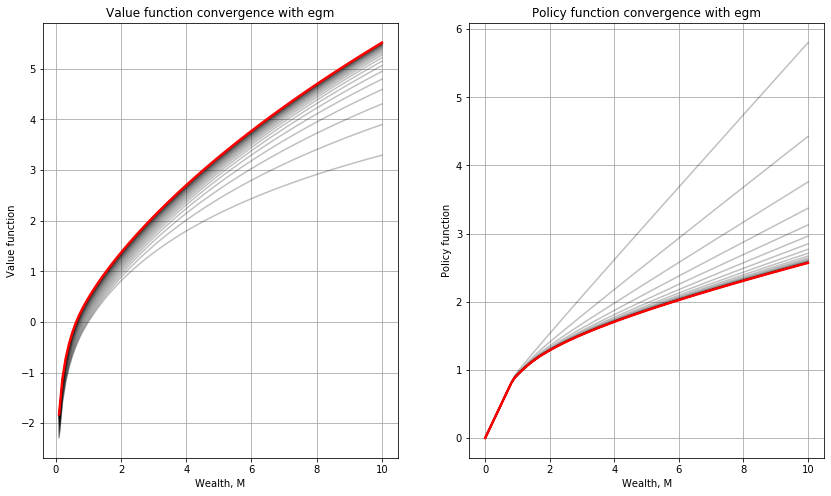

Average squared Euler residuals (egm) using 1000 points is 1.939394478573048e-05


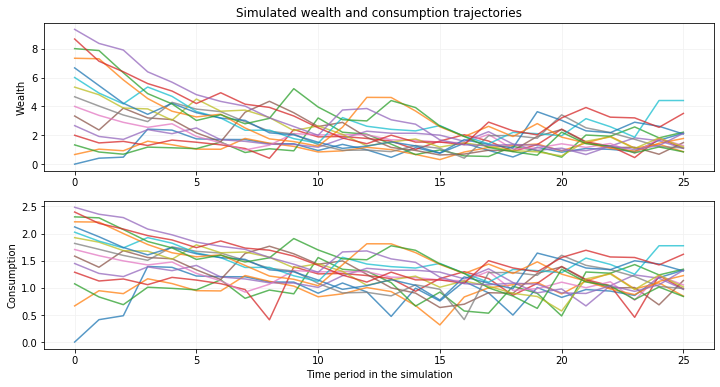

||||||||||||||||||||||||||

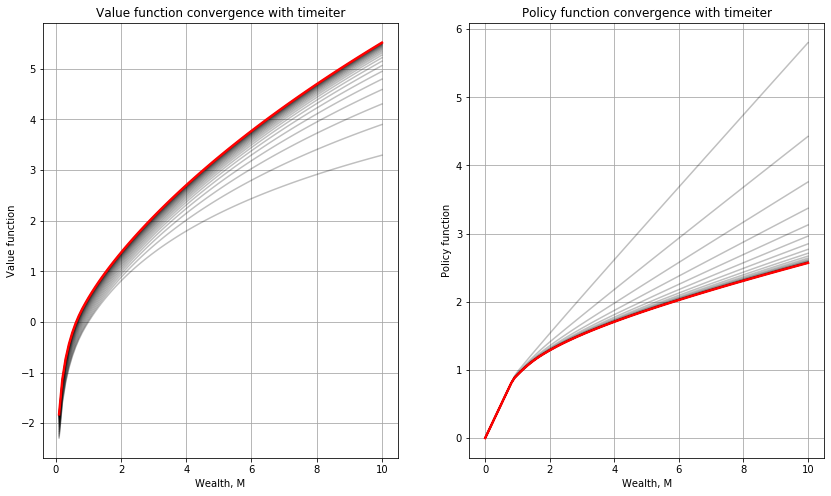

Average squared Euler residuals (time iterations) using 1000 points is 1.9068152530240724e-05


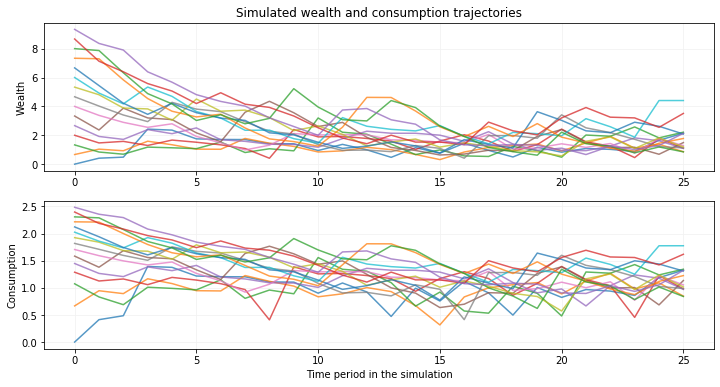

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

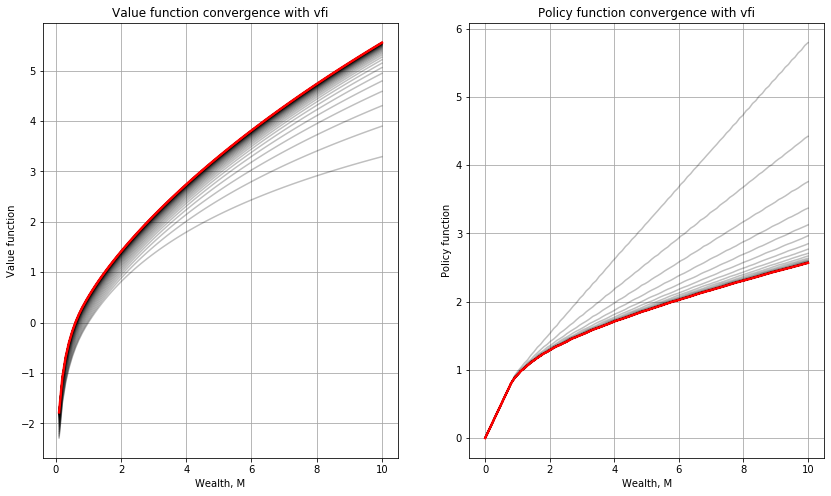

Average squared Euler residuals (VFI with continuous Bellman) using 1000 points is 2.434850041592656e-05


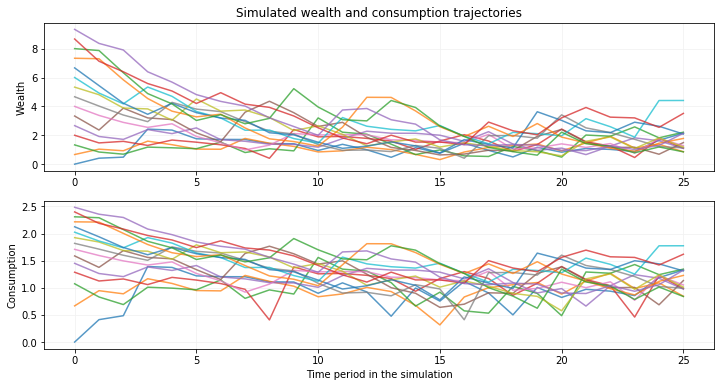

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

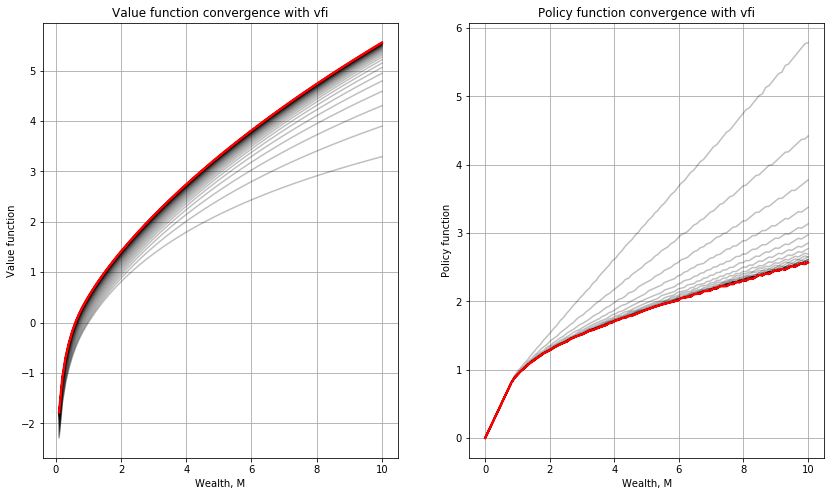

Average squared Euler residuals (VFI with discretized Bellman) using 1000 points is 0.04219940112956641


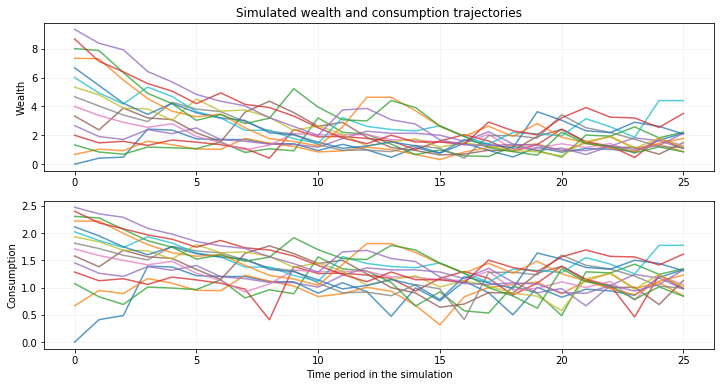

In [2]:
m = deaton(ngrid=100,nchgrid=250,sigma=.5,nquad=10, bellman_type='continuous')
print(m)

v,c = m.solve_plot(solver='egm')
m.accuracy(verbose=True)
sims = m.simulator(init_wealth=m.Mbar*np.arange(15)/15,T=25,seed=2020)

v,c = m.solve_plot(solver='timeiter')
m.accuracy(verbose=True)
sims = m.simulator(init_wealth=m.Mbar*np.arange(15)/15,T=25,seed=2020)

v,c = m.solve_plot(solver='vfi')
m.accuracy(verbose=True)
sims = m.simulator(init_wealth=m.Mbar*np.arange(15)/15,T=25,seed=2020)

m.bellman_type='discretized'
v,c = m.solve_plot(solver='vfi')
m.accuracy(verbose=True)
sims = m.simulator(init_wealth=m.Mbar*np.arange(15)/15,T=25,seed=2020)

Deaton model with beta=0.900, sigma=1.000, gross return=1.000
Grids: state 100 points up to 10.0, choice 250 points, quadrature 1 points
Interpolation: linear
The model is not solved.
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

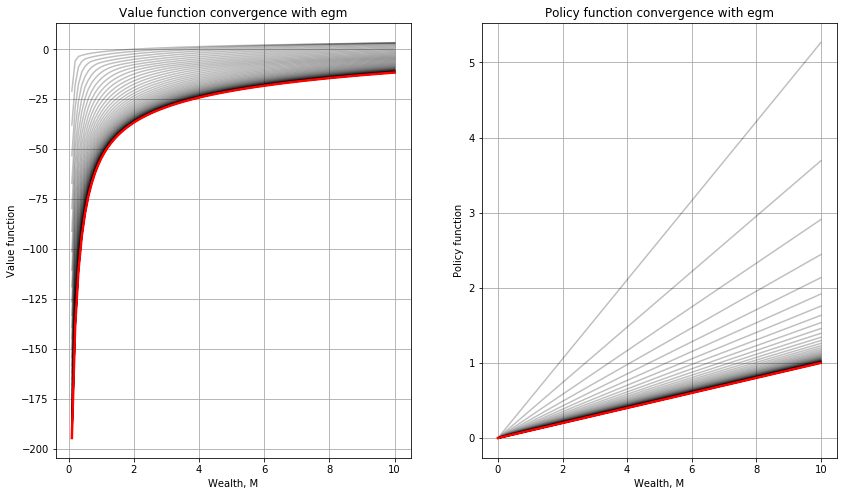

Average squared Euler residuals (egm) using 1000 points is 1.4981111053843799e-05


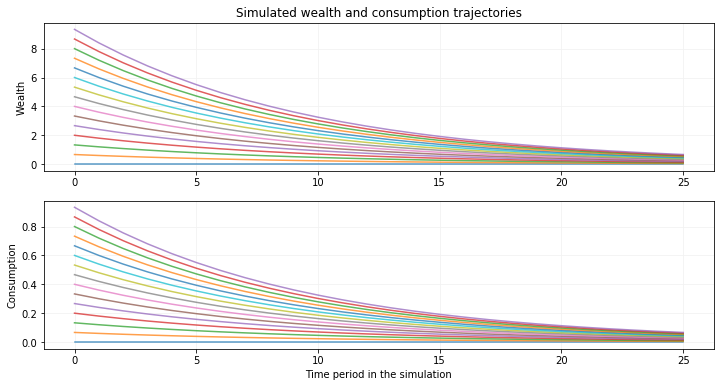

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

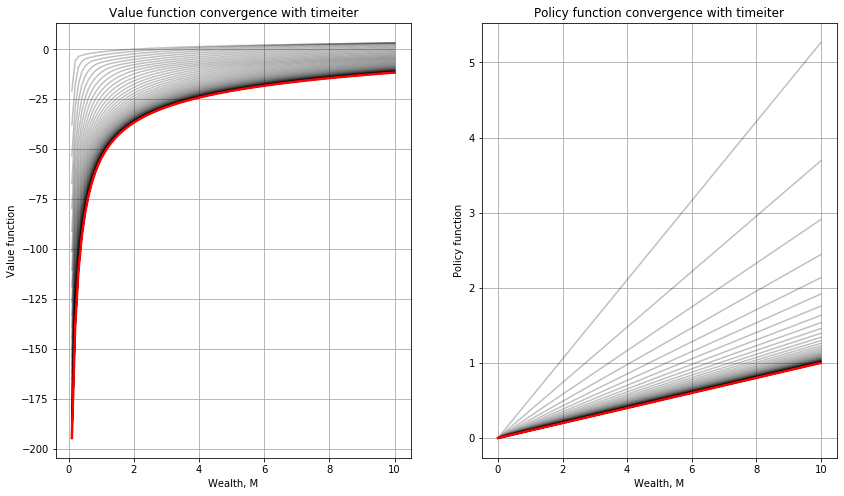

Average squared Euler residuals (time iterations) using 1000 points is 1.4981108752018307e-05


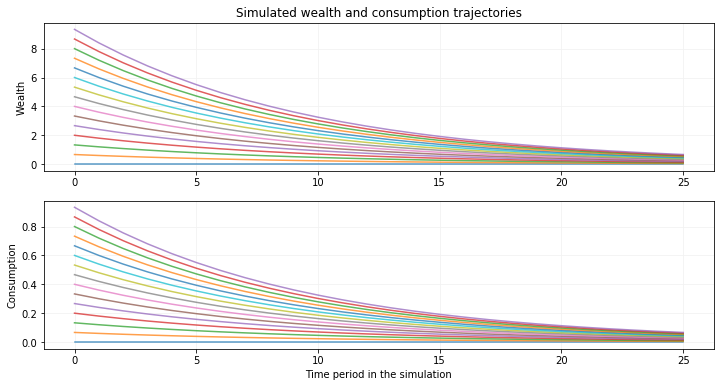

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

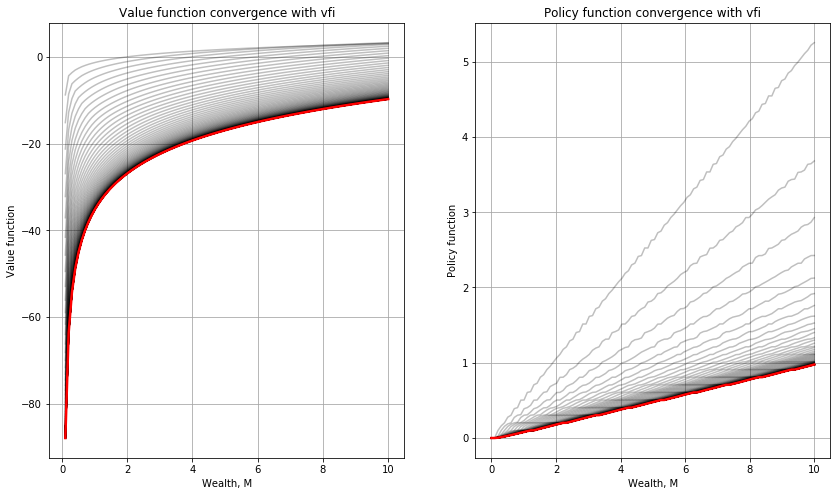

Average squared Euler residuals (VFI with continuous Bellman) using 1000 points is 8650.660106633046


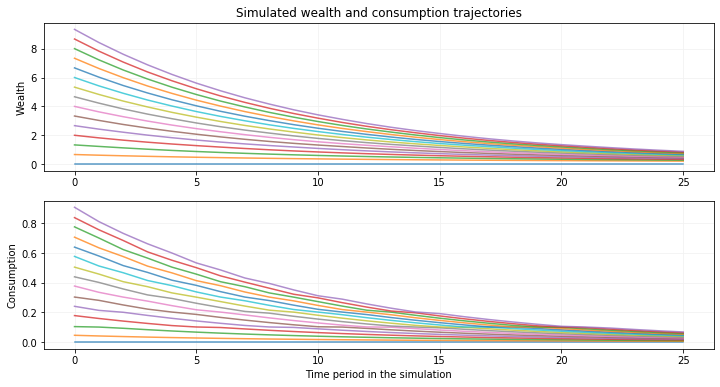

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

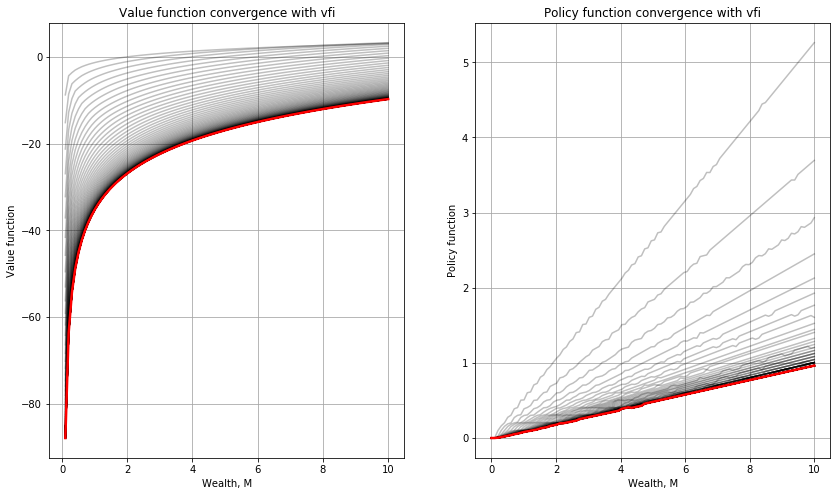

Average squared Euler residuals (VFI with discretized Bellman) using 1000 points is 8926.290761437984


In [3]:
# same with no income and no returns on savings (cake eating)
m = deaton(ngrid=100,nchgrid=250,nquad=1,R=1., bellman_type='continuous')  # nquad=1 is special case with no income
print(m)

v,c = m.solve_plot(solver='egm')
m.accuracy(verbose=True)
sims = m.simulator(init_wealth=m.Mbar*np.arange(15)/15,T=25,seed=2020)

v,c = m.solve_plot(solver='timeiter')
m.accuracy(verbose=True)
sims = m.simulator(init_wealth=m.Mbar*np.arange(15)/15,T=25,seed=2020)

v,c = m.solve_plot(solver='vfi')
m.accuracy(verbose=True)
sims = m.simulator(init_wealth=m.Mbar*np.arange(15)/15,T=25,seed=2020)

m.bellman_type='discretized'
v,c = m.solve_plot(solver='vfi')
m.accuracy(verbose=True)

In [4]:
%%timeit -n10 -r10 m = deaton(ngrid=100,nchgrid=250,sigma=.5,nquad=10, bellman_type='continuous')
m.solve_egm()

10.7 ms ± 807 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [5]:
%%timeit -n10 -r5 m = deaton(ngrid=100,nchgrid=250,sigma=.5,nquad=10, bellman_type='continuous')
m.solve_timeiter()

1.17 s ± 22.9 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


### Keane’s test

In deterministic consumption-savings model with $ \beta R = 1 $, we have perfect consumption smoothing:

$$
u'\big(c^\star(M)\big) = \beta R \mathbb{E}_{y} u'\big(c^\star\big(\underset{=M'}{\underbrace{R[M-c^\star(M)]+\tilde{y}}}\big)\big)
$$

$$
u'\big(c^\star(M)\big) = u'\big(c^\star(M')\big) \Rightarrow
c^\star(M) = c^\star(M')
$$

Simulation from the solution of such model should produce completely smooth consumption path, provided the solution is accurate.

Average squared Euler residuals (VFI with continuous Bellman) using 1000 points is 3.2496007179816775e-05
Average squared Euler residuals (time iterations) using 1000 points is 3.249597105381732e-05
Average squared Euler residuals (egm) using 1000 points is 3.249597103772514e-05


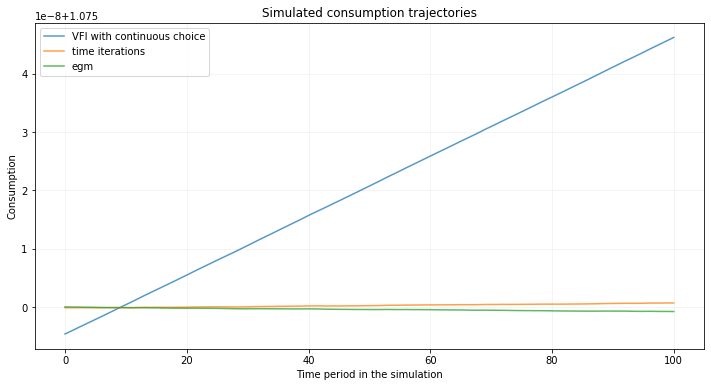

In [6]:
init_wealth,T = 1.75,100
m = deaton(beta=0.9,R=1/0.9,ngrid=100,nchgrid=250,sigma=1e-10,nquad=2)

# v,c = m.solve_vfi()
# m.accuracy(verbose=True)
# sims1 = m.simulator(init_wealth=init_wealth,T=T,seed=2020,plot=False)

m.bellman_type='continuous'
v,c = m.solve_vfi(tol=1e-8, maxiter=1000)
m.accuracy(verbose=True)
sims2 = m.simulator(init_wealth=init_wealth,T=T,seed=2020,plot=False)

v,c = m.solve_timeiter(tol=1e-10)
m.accuracy(verbose=True)
sims3 = m.simulator(init_wealth=init_wealth,T=T,seed=2020,plot=False)

v,c = m.solve_egm(tol=1e-10)
m.accuracy(verbose=True)
sims4 = m.simulator(init_wealth=init_wealth,T=T,seed=2020,plot=False)

fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.set_title('Simulated consumption trajectories')
ax.set_ylabel('Consumption')
ax.set_xlabel('Time period in the simulation')
ax.grid(b=True, which='both', color='0.95', linestyle='-')
# ax.plot(sims1['c'][0,:],alpha=0.75,label='VFI with discretized choice')
ax.plot(sims2['c'][0,:],alpha=0.75,label='VFI with continuous choice')
ax.plot(sims3['c'][0,:],alpha=0.75,label='time iterations')
ax.plot(sims4['c'][0,:],alpha=0.75,label='egm')
ax.legend()
plt.show()

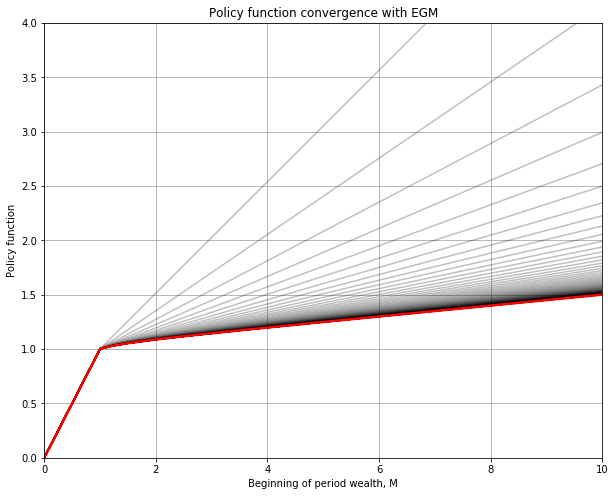

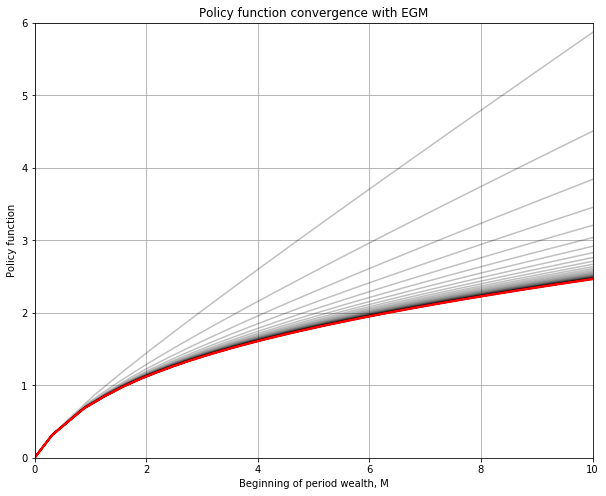

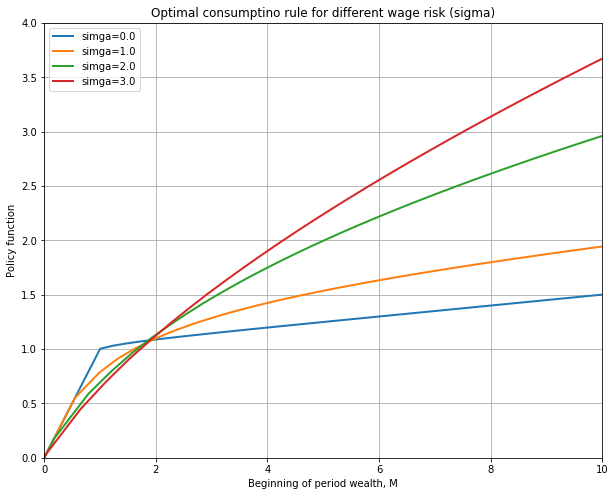

In [7]:
# Another implementation of only EGM in stochastic consumption-savings model

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import lognorm

class deaton2():
    '''Implementation of the stochastic Deaton consumption-savings problem with income.
    '''
    def __init__(self, beta=.9, R=1.05, sigma=1,
                 Mbar=10, ngrid=50, nquad=10):
        self.beta = beta    # Discount factor
        self.Mbar = Mbar    # Upper bound on wealth
        self.R = R          # Gross interest
        self.sigma = sigma  # Param in log-normal income distribution
        self.ngrid = ngrid  # Number of grid points for post-decision space
        self.nquad = nquad  # Number of quadrature points
        # quadrature points and weights for log-normal distribution
        self.quadp,self.quadw = np.polynomial.legendre.leggauss(nquad) # Gauss-Legendre for [-1,1]
        self.quadp = (self.quadp+1)/2 # rescale t0 [0,1]
        self.quadw /= 2 # rescale weights as well
        self.quadp = lognorm.ppf(self.quadp,sigma) # inverse cdf
        self.quadp = self.quadp.reshape([-1,1]) # column-vector
        self.quadw = self.quadw.reshape([1,-1]) # row-vector

    def u(self,c):
        '''Utility function'''
        return np.log(c)

    def mu(self,c):
        '''Marginal utility function'''
        return 1/c

    def imu(self,u):
        '''Inverse marginal utility function'''
        return 1/u

    def next_period_wealth(self,A):
        '''Next period budget as function of post-decision wealth.
           Returns array for each quadrature point in income.
        '''
        # shocks in rown, states in columns
        return self.R*A.reshape([1,-1]) + self.quadp

    def solve (self, maxiter=100, tol=1e-4, callback=None):
        '''Solver the model using endogenous gridpoint method
        '''
        A = np.linspace(0,self.Mbar,self.ngrid) # grid over savings
        gr0 = np.array([0,self.Mbar]) # grid of two points
        c0 = np.array([0,self.Mbar]) # on first iteration assume consuming everything
        inter0 = interpolate.interp1d(gr0,c0,kind='slinear',fill_value="extrapolate") # interpolate policy function
        for iter in range(maxiter):
            # EGM step
            nxM = self.next_period_wealth(A) # next period M
            nxc = inter0(nxM) # consumption next period
            expc = self.quadw @ self.mu(nxc) # expectation of mu next period
            RHS = self.beta*self.R*expc
            c1 = np.empty(self.ngrid+1) # one extra point
            gr1 = np.empty(self.ngrid+1) # one extra point
            c1[0] = 0.
            c1[1:] = self.imu(RHS) # consumption this period
            gr1[0] = 0
            gr1[1:] = c1[1:] + A
            inter1 = interpolate.interp1d(gr1,c1,kind='slinear',fill_value="extrapolate")
            if callback: callback(iter,gr1,np.full(gr1.shape,np.nan),c1) # callback for making plots (value function not implemented)
            dev = np.abs( inter1(gr0[1:]) - c0[1:] ) # interpolate new policy on old grid
            if np.all(dev < tol):
                break
            gr0 = gr1
            c0 = c1
            inter0 = inter1
        else:  # when i went up to maxiter
            print('No convergence: maximum number of iterations achieved!')
        return c1,gr1

    def solve_plot(self, **kvarg):
        '''Illustrate solution
           Inputs: solver (string), and any inputs to the solver
        '''
        fig, ax = plt.subplots(1,1,figsize=(10,8))
        ax.grid(b=True, which='both', color='0.65', linestyle='-')
        def callback(iter,grid,v,c):
            ax.plot(grid,c,color='k',alpha=0.25)
        c,gr = self.solve(callback=callback,**kvarg)
        # add solutions
        ax.plot(gr,c,color='r',linewidth=2.5)
        ax.set_title('Policy function convergence with EGM')
        ax.set_xlim(right=self.Mbar,left=0.)
        ax.set_ylim(top=np.ceil(2*c[-1]),bottom=0.)
        ax.set_xlabel('Beginning of period wealth, M')
        ax.set_ylabel('Policy function')
        plt.show()
        return c,gr

m = deaton2(sigma=1e-8,R=1.05,beta=.95,nquad=1)
c,gr = m.solve_plot()

m = deaton2(sigma=1.5,R=1.05,beta=.95,nquad=15)
c,gr = m.solve_plot()

fig, ax = plt.subplots(1,1,figsize=(10,8))
for s in [1e-8,1,2,3]:
    m = deaton2(R=1.05,beta=.95,nquad=7, sigma=s)
    c,gr = m.solve()
    ax.plot(gr,c,linewidth=2.0, label='simga=%0.1f'%s)
ax.set_xlim(right=10,left=0.)
ax.set_ylim(top=4,bottom=0.)
ax.set_title('Optimal consumptino rule for different wage risk (sigma)')
ax.set_xlabel('Beginning of period wealth, M')
ax.set_ylabel('Policy function')
ax.grid(b=True, which='both', color='0.65', linestyle='-')
ax.legend()
plt.show()